In [38]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
from matplotlib.pyplot import style


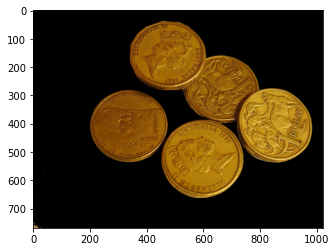

In [39]:
# Question1: Meanshift
img11 = cv2.imread("imgQ12-1.png")
img11_rgb = cv2.cvtColor(img11, cv2.COLOR_BGR2RGB)

plt.imshow(img11_rgb)
# plt.xticks([]), plt.yticks([]) # to hide tick values on x and y
plt.show()

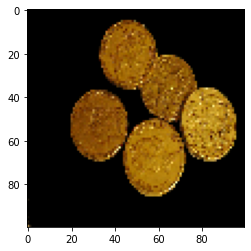

In [40]:
# image compression 
img_res = cv2.resize(img11_rgb, (100,100), interpolation = cv2.INTER_CUBIC)
plt.imshow(img_res)

In [41]:
# Meanshift

#   red, green, blue = cv2.split(img)
red = img_res[ :, :, 0]
green = img_res[ :, :, 1]
blue = img_res[ :, :, 2]
# plt.imshow(red)

orginal_shape = red.shape
print(orginal_shape)

colour_samples = np.column_stack([red.flatten(),green.flatten(), blue.flatten()])

colour_samples.shape

(100, 100)


(10000, 3)

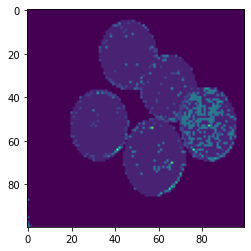

In [42]:
ms_clf = MeanShift(bandwidth= 20,bin_seeding=True)
ms_labels= ms_clf.fit_predict(colour_samples).reshape(orginal_shape)


plt.imshow(ms_labels)

# colors = [['red', 'green', 'blue', 'grey'][i]for i in ms_labels]
# plt.scatter(ms_labels[:,0], ms_labels[:,1], c=colors, s=10)
# plt.title("meanshift")


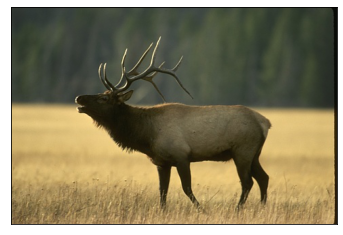

In [43]:
# Question2. watershed


# imgQ41.jpg
# imgQ12-1.png
img22 = cv2.imread("imgQ41.jpg")
img22_rgb = cv2.cvtColor(img22, cv2.COLOR_BGR2RGB)

plt.imshow(img22_rgb)
plt.xticks([]), plt.yticks([]) # to hide tick values on x and y
plt.show()


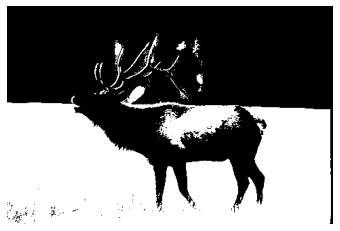

In [44]:
img22_gray = cv2.cvtColor(img22_rgb, cv2.COLOR_RGB2GRAY)
# img_thresh = img22_gray

ret, img_thresh =cv2.threshold(img22_gray, 90, 255, cv2.THRESH_BINARY)
# ret, img_thresh =cv2.threshold(img22_gray,  70, 255, cv2.THRESH_BINARY_INV)
# ret, img_thresh =cv2.threshold(img22_gray,  70, 255, cv2.THRESH_TRUNC)
# ret, img_thresh =cv2.threshold(img22_gray,  70, 255, cv2.THRESH_TOZERO_INV)
# athdGAU =cv2.adaptiveThreshold(img22_gray,  255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,3 )

# img_thresh =cv2.adaptiveThreshold(img22_gray,  255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,5,3 )

# ret, img_thresh =cv2.threshold(img22_gray,  0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# ret, img_thresh =cv2.threshold(img22_gray,  0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


plt.imshow(img_thresh, cmap = 'gray')
plt.axis('off')
plt.show()

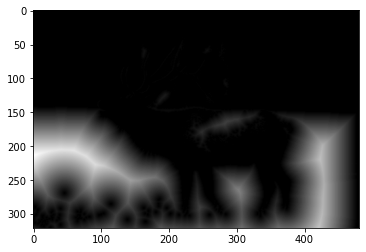

In [45]:
##方法一：：：
distance = ndi.distance_transform_edt(img_thresh)
plt.imshow(distance, cmap = 'gray')

(<matplotlib.image.AxesImage at 0x7ff18c5ee650>, (-0.5, 480.5, 320.5, -0.5))

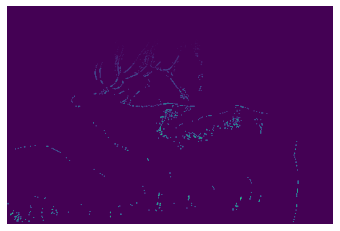

In [46]:
local_maxi = peak_local_max(distance, indices = False, footprint =np.ones((3,3)), labels =img_thresh)

markers = ndi.label(local_maxi)[0]
plt.imshow(markers),plt.axis("off")

(-0.5, 480.5, 320.5, -0.5)

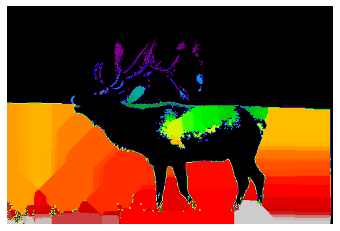

In [47]:
# 
ws_labels = watershed(-distance, markers, mask=img_thresh)
plt.imshow(ws_labels, cmap = plt.cm.nipy_spectral)
plt.axis("off")

In [48]:
## 方法二：：：：

Text(0.5, 1.0, 'nosie removal')

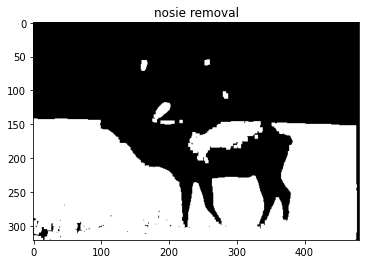

In [49]:
# noise removal 形态学闭运算，去除白噪声，为了去除对象上的小的空洞，
kernel =np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN,kernel, iterations= 2)
plt.imshow(opening, 'gray')
plt.title("nosie removal")


Text(0.5, 1.0, 'sure background area')

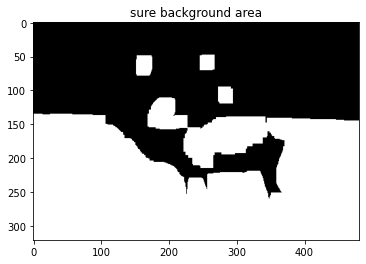

In [50]:
# sure background area (dilate 膨胀操作)
sure_bg = cv2.dilate(opening, kernel,iterations = 7)

plt.imshow(sure_bg, 'gray')
plt.title("sure background area")




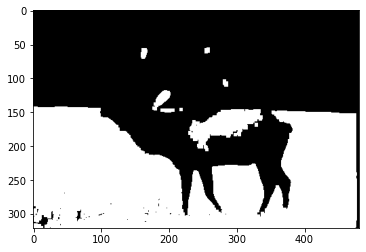

In [51]:
# find sure foregroud area, 
# 距离变化的基本含义就是计算一个图像中非零像素点到最近的零像素点的距离，也就是，到零像素点的最短距离

# 最常见的距离变换算法就是通过连续的腐蚀操作来实现，腐蚀操作的停止条件是所有前景的像素被完全腐蚀。
# 这样根据腐蚀的先后顺序，我们就可以得到各个前景像素点到前景中心骨架像素点的距离。
# 根据各个像素点的距离值，设置不同的灰度值，这样就完成了二值图像的距离变换。
# cv2.DIST_L2

dist_transform =cv2.distanceTransform(opening,cv2.DIST_L2,5)

# local_maxi = peak_local_max(dist_transform, indices = False, footprint=kernel, labels = img_thresh)
# markers = ndi.label(local_maxi)[0]

ret, sure_fg = cv2.threshold(dist_transform, 0.0001*dist_transform.max(), 255, 0 )


plt.imshow(sure_fg, 'gray')


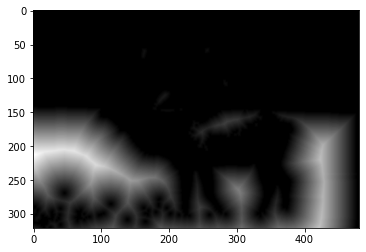

In [52]:
plt.imshow(dist_transform, 'gray')

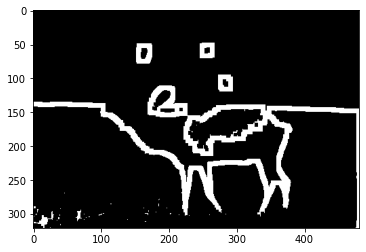

In [53]:
# Find unkown region
sure_fg =np.uint8(sure_fg)
unkown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unkown,'gray')

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7ff18cd1a5d0>)

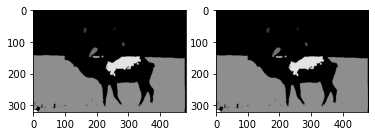

In [54]:
# mark labelling
ret, markers1 =cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1 
markers = markers1+1

#  now, mark  the region of unkown with zero
markers[unkown==255] =0

plt.subplot(1,2,1),plt.imshow(markers1, 'gray')

plt.subplot(1,2,2),plt.imshow(markers, 'gray')

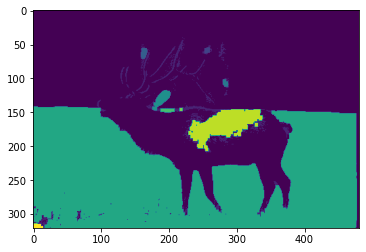

In [55]:
# 结果使用JET颜色地图表示，深蓝区域表示未知区域。
# 肯定硬币的区域使用不同的颜色标记。其余区域就是用浅蓝色标记的背景

# 现在标签准备好了，到最后一步：实施watershed算法。标签图像会被修改，边界区域的标记变为-1

# markers3 = cv2.watershed(img22_rgb, markers)

markers3 = watershed(-dist_transform, markers, mask=img_thresh)

img22_rgb[markers==-1] = [255,0,0]

plt.imshow(markers3)


(-0.5, 480.5, 320.5, -0.5)

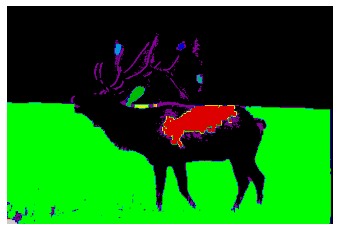

In [56]:
plt.imshow(markers3, cmap = plt.cm.nipy_spectral)
plt.axis("off")

In [ ]:

# Question3


